# Fit MNIST dataset using a multilayer perceptron

Very inspired ...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import idx2numpy

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
from lib.mlp import MLP

## Load data

In [4]:
def normalize_data(data):

    data = data.reshape(data.shape[0], 28 * 28).T
    
    # Standarize data
    data = (data - data.mean(axis=0)) / data.std(axis=0)

    # Keep data in a good range of value to avoid the vanishing
    # or exploding gradient problems
    data /= 3
    
    return data

In [5]:
def normalize_labels(labels):

    # One-hot encode the labels
    labels = np.eye(10)[labels].T

    return labels

In [6]:
# Load train data and labels

raw_x_train = idx2numpy.convert_from_file('./data/mnist/train-images-idx3-ubyte')
x_train = normalize_data(raw_x_train)

raw_y_train = idx2numpy.convert_from_file('./data/mnist/train-labels-idx1-ubyte')
y_train = normalize_labels(raw_y_train)

# Load test data and labels

raw_x_test = idx2numpy.convert_from_file('./data/mnist/t10k-images-idx3-ubyte')
x_test = normalize_data(raw_x_test)

raw_y_test = idx2numpy.convert_from_file('./data/mnist/t10k-labels-idx1-ubyte')
y_test = normalize_labels(raw_y_test)

# Train model

In [7]:
def get_accuracy(raw_predictions, raw_labels):
    return (raw_labels == raw_predictions).mean()

In [8]:
def evaluate_accuracy(model, data, raw_labels):
    predictions = model.predict(data)
    raw_predictions = np.argmax(predictions, axis=0)
    accuracy = get_accuracy(raw_predictions, raw_labels)
    return accuracy

In [9]:
mlp = MLP(layers=[28 * 28, 100, 100, 100, 10])

In [10]:
%%time

epochs = 30

for epoch in range(1, epochs + 1):
    mse = mlp.fit(x_train, y_train, epochs=1, batch_size=100, eta=3)
    train_accuracy = evaluate_accuracy(mlp, x_train, raw_y_train) * 100
    test_accuracy = evaluate_accuracy(mlp, x_test, raw_y_test) * 100
    
    print('epoch %i, loss = %.3f, train accuracy = %.1f%%, test_accuracy = %.1f%%' %
          (epoch, mse, train_accuracy, test_accuracy))

print()

epoch 1, loss = 0.251, train accuracy = 61.6%, test_accuracy = 62.5%
epoch 2, loss = 0.153, train accuracy = 74.5%, test_accuracy = 74.6%
epoch 3, loss = 0.106, train accuracy = 84.8%, test_accuracy = 84.4%
epoch 4, loss = 0.090, train accuracy = 86.3%, test_accuracy = 85.8%
epoch 5, loss = 0.038, train accuracy = 95.6%, test_accuracy = 95.0%
epoch 6, loss = 0.032, train accuracy = 96.2%, test_accuracy = 95.6%
epoch 7, loss = 0.030, train accuracy = 96.5%, test_accuracy = 95.9%
epoch 8, loss = 0.025, train accuracy = 97.1%, test_accuracy = 96.2%
epoch 9, loss = 0.022, train accuracy = 97.5%, test_accuracy = 96.5%
epoch 10, loss = 0.020, train accuracy = 97.7%, test_accuracy = 96.7%
epoch 11, loss = 0.021, train accuracy = 97.5%, test_accuracy = 96.5%
epoch 12, loss = 0.016, train accuracy = 98.2%, test_accuracy = 96.9%
epoch 13, loss = 0.015, train accuracy = 98.3%, test_accuracy = 97.2%
epoch 14, loss = 0.015, train accuracy = 98.3%, test_accuracy = 97.0%
epoch 15, loss = 0.013, train

The ~97.5% accuracy on test set is conform to what is expected from a multilayer perceptron learning from MNIST dataset.

See [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/).

## Show some relevant predictions

In [19]:
# Plot example images and predictions
def plot_examples(raw_data, raw_labels, raw_predictions, subplots_nrows=1, subplots_ncols=4, cmap='Greys'):

    assert raw_data.shape[0] == len(raw_predictions)
    
    fig, plts = plt.subplots(subplots_nrows, subplots_ncols)

    if subplots_nrows == 1:
        plts = [plts]
    
    for i in range(subplots_nrows):
        for j in range(subplots_ncols):

            # Subplot index
            k = i * (subplots_nrows + 1) + j

            # Stop plotting if examples are exhausted
            if k > len(raw_predictions):
                break

            # Plot
            plts[i][j].imshow(raw_data[k], cmap=cmap)
            plts[i][j].axis('off')
            plts[i][j].set_title('predicted: {prediction}\nground truth: {label}'.
                                 format(label=raw_labels[k], prediction=raw_predictions[k]))

    # Set layout
    fig.set_figheight(1.8 * subplots_nrows)
    fig.set_figwidth(1.8 * subplots_ncols)
    fig.tight_layout()

In [20]:
# For each image, get prediction for each class
p_test = mlp.predict(x_test)

# For each image, get predicted class
raw_p_test = np.argmax(p_test, axis=0)

# For each image, get prediction strengh
# How sure is it that the prediction is the correct one?
prediction_strengh = p_test[raw_p_test, np.arange(p_test.shape[1])]
# How sure is it that the true class is the correct one?
prediction_strengh += p_test[raw_y_test, np.arange(y_test.shape[1])]

# Get indices of images by decreasing prediction strengh
strengh_indices = prediction_strengh.argsort()[::-1]

# For each image, check if the prediction is correct
is_correct = raw_p_test == raw_y_test
# Sort by decreasing prediction strengh
is_correct = is_correct[strengh_indices]

### Correct predictions that are the most uncertain

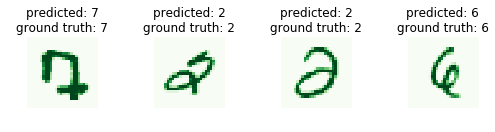

In [21]:
least_correct = strengh_indices[::-1][is_correct[::-1] == True]
plot_examples(raw_x_test[least_correct], raw_y_test[least_correct], raw_p_test[least_correct],
              cmap='Greens')

### Incorrect predictions that were the most certain

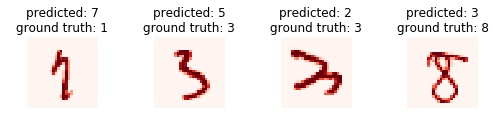

In [23]:
most_incorrect = strengh_indices[is_correct == False]
plot_examples(raw_x_test[most_incorrect], raw_y_test[most_incorrect], raw_p_test[most_incorrect],
              cmap='Reds')

## Same as above using Keras

In [25]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense
from keras.optimizers import SGD

In [26]:
%%time

mlp = Sequential()
mlp.add(Dense(100, input_shape=(28 * 28,), activation='sigmoid'))
mlp.add(Dense(100, activation='sigmoid'))
mlp.add(Dense(100, activation='sigmoid'))
mlp.add(Dense(10, activation='sigmoid'))
mlp.compile(optimizer=SGD(lr=3), loss='mse', metrics=['accuracy'])
mlp.fit(x_train.T, y_train.T, validation_data=(x_test.T, y_test.T), batch_size=5, nb_epoch=15)
print()

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 24s - loss: 0.0300 - acc: 0.7691 - val_loss: 0.0122 - val_acc: 0.9217
Epoch 2/15
60000/60000 [==============================] - 23s - loss: 0.0089 - acc: 0.9430 - val_loss: 0.0085 - val_acc: 0.9459
Epoch 3/15
60000/60000 [==============================] - 23s - loss: 0.0064 - acc: 0.9593 - val_loss: 0.0062 - val_acc: 0.9606
Epoch 4/15
60000/60000 [==============================] - 16s - loss: 0.0051 - acc: 0.9681 - val_loss: 0.0057 - val_acc: 0.9644
Epoch 5/15
60000/60000 [==============================] - 17s - loss: 0.0042 - acc: 0.9737 - val_loss: 0.0056 - val_acc: 0.9645
Epoch 6/15
60000/60000 [==============================] - 22s - loss: 0.0036 - acc: 0.9774 - val_loss: 0.0046 - val_acc: 0.9708
Epoch 7/15
60000/60000 [==============================] - 27s - loss: 0.0032 - acc: 0.9805 - val_loss: 0.0050 - val_acc: 0.9679
Epoch 8/15
60000/60000 [==============================

Same accuracy on test set: ~97.5%.